# **GRADY DATA: Transfusion Response Analysis with median SpO2, Hb, S/F (SpO2/FiO2), P/F (PaO2/FiO2) and blood volume (ml)**

**BeforeT: 24 hrs before T to T time, AfterT: T+4 hrs to T+4+$\tau$ hrs, where $\tau$=3,6,9,12**

find del_Hb, del_SpO2, S/F, P/F

Remove bed criteria to include more patients

In [53]:
import pandas as pd
from datetime import datetime
import os
import pickle
from datetime import timedelta
from datetime import datetime
from datetime import date
from datetime import time
from dateutil.relativedelta import relativedelta
import random
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np

import wfdb
from tqdm import tqdm

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import time

import warnings
warnings.filterwarnings('ignore') 
# warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
path = "/labs/kamaleswaranlab/MODS/Data/Grady_Data/2. Fluids & Meds/Blood Products/"

In [3]:
os.listdir('/labs/kamaleswaranlab/MODS/Data/Grady_Data/')

['7. Radiology',
 '6. Vent',
 '4. Patient Assessments',
 '8. Lines',
 '2. Fluids & Meds',
 '5. ICD Codes',
 '1. Administrative Attributes',
 '3. Labs & Cultures',
 'meta_data']

In [6]:
os.listdir('/labs/kamaleswaranlab/MODS/Data/Grady_Data/1. Administrative Attributes/Encounters/')

['encounter_2014_decomp_03112020.txt',
 'encounter_2015_decomp_03112020.txt',
 'encounter_2016_decomp_03112020.txt',
 'encounter_2017_decomp_03112020.txt',
 'encounter_2018_decomp_03112020.txt',
 'encounter_2020_decomp_07222020.txt',
 'encounters_2019_decomp_04272020.txt',
 'archive',
 '.encounter_2016_decomp_03112020.txt.swp',
 '.encounter_2017_decomp_03112020.txt.swp',
 'encounter_2021_decomp_05032022.txt',
 'encounter_2022_decomp_11082022.txt',
 'encounter_2014-2022_decomp_by_MRN_04112023.txt',
 'encounter_2021_09062023.txt',
 'encounter_2022_09062023.txt']

In [65]:
# years = ['2016','2017','2018','2019','2020']

# All_icu_pat = pd.DataFrame()
# for year in years:
#     dir1 = '/labs/kamaleswaranlab/MODS/Data/Grady_Data/'  
#     ### ICU adult patients: 
#     files1 = [filename for filename in os.listdir(dir1+'1. Administrative Attributes/Encounters/') if filename.startswith('encounter_'+str(year))]
#     if year == '2019':
#         files1 = [filename for filename in os.listdir(dir1+'1. Administrative Attributes/Encounters/') if filename.startswith('encounters_'+str(year))]
#     bedFilePath = dir1+'1. Administrative Attributes/Encounters/'+files1[0]
#     bedPat = pd.read_csv(bedFilePath, sep='|', low_memory=False)
#     icuPat = bedPat[~bedPat.total_icu_days.isnull()]
#     icuPat = icuPat[icuPat.age>18]
#     icuPat.csn = icuPat.csn.astype(int)
#     icuPat['pat_id'] = icuPat['pat_id'].astype(str) 
#     icuPat['year'] = str(year)
#     All_icu_pat = pd.concat([All_icu_pat, icuPat], axis=0)
# All_icu_pat.drop_duplicates(inplace=True)        
# All_icu_pat.reset_index(drop=True, inplace=True)
# All_icu_pat

**Adding CSNs into Patient Directory along with PAT_ID**

In [7]:
years = ['2016','2017','2018','2019','2020']

All_Vent_Pat_bed_matched_total = pd.DataFrame()
pat_total = 0
csn_total = 0

count=0
for year in years:
    dir1 = '/labs/kamaleswaranlab/MODS/Data/Grady_Data/'
    
    ###(1) ICU adult patients: 

    files1 = [filename for filename in os.listdir(dir1+'1. Administrative Attributes/Encounters/') if filename.startswith('encounter_'+str(year))]
    if year == '2019':
        files1 = [filename for filename in os.listdir(dir1+'1. Administrative Attributes/Encounters/') if filename.startswith('encounters_'+str(year))]
    bedFilePath = dir1+'1. Administrative Attributes/Encounters/'+files1[0]
    bedPat = pd.read_csv(bedFilePath, sep='|', low_memory=False)
    icuPat = bedPat[~bedPat.total_icu_days.isnull()]
    icuPat = icuPat[icuPat.age>18]
    icuPat.csn = icuPat.csn.astype(int)
    
    pat = len(icuPat['pat_id'].unique())
    csn = len(icuPat['csn'].unique())
    print(f'All total patients in {year}-- #pat_ids: {pat}, #CSNs: {csn}')
    pat_total = pat_total + pat
    csn_total = csn_total + csn
     
        
    icuPat['PAT_ID'] = icuPat['pat_id']
    icuPat['pat_id'] = icuPat['pat_id'].astype(str)


    All_Vent_Pat_bed_matched = icuPat 

    All_Vent_Pat_bed_matched['year'] = str(year)

    #Creating a dataframe with all data pertaining to waveform identifiers from the list given

    All_Vent_Pat_bed_matched_total = pd.concat([All_Vent_Pat_bed_matched_total, All_Vent_Pat_bed_matched], axis=0)
        
print(f'Total patients throughout the years-- #pat_ids: {pat_total}, #CSNs: {csn_total}')
#debedWav = len(All_Vent_Pat_bed_matched_total['deBedTime'].unique())
patWav = len(All_Vent_Pat_bed_matched_total['PAT_ID'].unique())
csnWav = len(All_Vent_Pat_bed_matched_total['csn'].unique())
yrsWav = All_Vent_Pat_bed_matched_total['year'].unique()
print(f'Total patients admitted (no having waveforms criterion)-- #pat_ids: {patWav}, #CSNs: {csnWav}, #Years: {yrsWav}')

All total patients in 2016-- #pat_ids: 3647, #CSNs: 3853
All total patients in 2017-- #pat_ids: 3455, #CSNs: 3629
All total patients in 2018-- #pat_ids: 3460, #CSNs: 3626
All total patients in 2019-- #pat_ids: 4178, #CSNs: 4439
All total patients in 2020-- #pat_ids: 3015, #CSNs: 3216
Total patients throughout the years-- #pat_ids: 17755, #CSNs: 18763
Total patients admitted (no having waveforms criterion)-- #pat_ids: 16945, #CSNs: 18762, #Years: ['2016' '2017' '2018' '2019' '2020']


In [8]:
All_Vent_Pat_bed_matched_total.drop_duplicates(inplace=True)

In [9]:
# All_Vent_Pat_bed_matched_total['csn'] = All_Vent_Pat_bed_matched_total['csn'].astype('int64')
# All_Vent_Pat_bed_matched_total['csn']

In [ ]:
All_Vent_Pat_bed_matched_total

In [11]:
All_Vent_Pat_bed_matched_total=All_Vent_Pat_bed_matched_total.reset_index()

In [12]:
All_Vent_Pat_bed_matched_total.dtypes

index                             int64
pat_id                           object
csn                               int64
har                             float64
mrn                               int64
study_id                        float64
age                             float64
zip_code                         object
ed_arrival_source                object
pre_admit_location               object
ed_presentation_time             object
hospital_admission_date_time     object
hospital_discharge_date_time     object
admit_reason                     object
insurance_status                 object
cpr_in_ed                        object
total_icu_days                  float64
total_vent_days                 float64
total_hosp_days                 float64
discharge_status                 object
discharge_to                     object
encounter_type                   object
PAT_ID                           object
year                             object
dtype: object

In [13]:
print(len(All_Vent_Pat_bed_matched_total.csn.unique()))
print(len(All_Vent_Pat_bed_matched_total.pat_id.unique()))

18762
16945


**Finding CSNs undergoes to Transfusion from Patient Directory**

In [16]:
df_transfusion = pd.read_csv('/labs/kamaleswaranlab/MODS/Data/Grady_Data/2. Fluids & Meds/Blood Products/blood_transfusion_2014-2022_decomp_by_MRN_04102023.txt', sep="|")

In [ ]:
df_transfusion.drop_duplicates(inplace=True)
df_transfusion.reset_index(drop=True, inplace=True)
df_transfusion

In [20]:
yearsT = All_Vent_Pat_bed_matched_total.year.unique()
print(f'How many years of patients bed-data present: {yearsT}')

# #How many years of waveform data
# yearsW = sorted((pd.to_datetime(All_Pat_file['DateStart']).dt.year).unique())
# print(f'How many years of waveform data present: {yearsW}')

yearsTrans = sorted((pd.to_datetime(df_transfusion['transfusion_start']).dt.year).unique())
print(f'How many years of transfusion data present: {yearsTrans}')

How many years of patients bed-data present: ['2016' '2017' '2018' '2019' '2020']
How many years of transfusion data present: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [21]:
df_transfusion['year'] = pd.to_datetime(df_transfusion['transfusion_start']).dt.year

In [22]:
df_transfusion['year'].unique()

array([2014, 2015, 2016, 2020, 2017, 2018, 2019, 2021, 2022, 2023])

In [24]:
from collections import Counter
w = Counter(df_transfusion.blood_product_name)

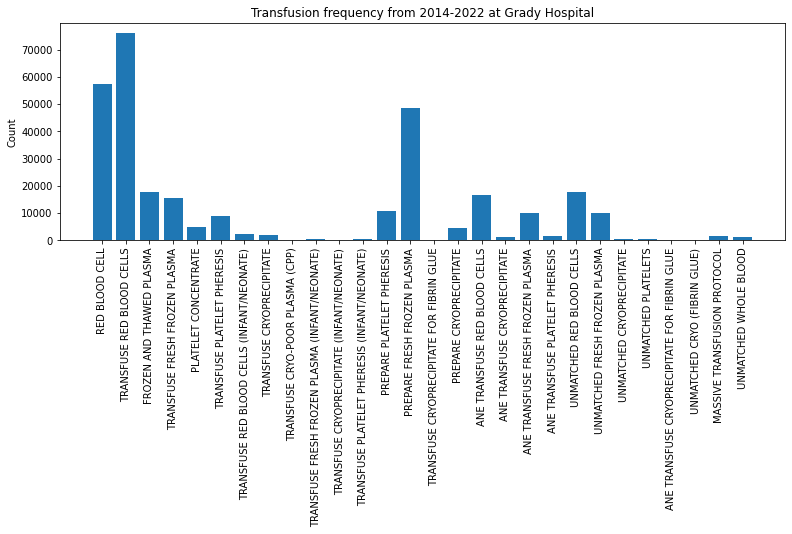

In [30]:
plt.figure(figsize=[13,4])
plt.bar(w.keys(), w.values())
y_pos = range(len(w.keys()))
# Rotation of the bars names
plt.xticks(y_pos, w.keys(), rotation=90)
plt.title('Transfusion frequency from 2014-2022 at Grady Hospital')
plt.ylabel('Count')
plt.show()

In [ ]:
df_transfusion_years = pd.DataFrame()
for yr in years:
    df_transfusion_y = df_transfusion[df_transfusion['year'] == int(yr)]
    df_transfusion_years = pd.concat([df_transfusion_years, df_transfusion_y], axis=0)
df_transfusion_years

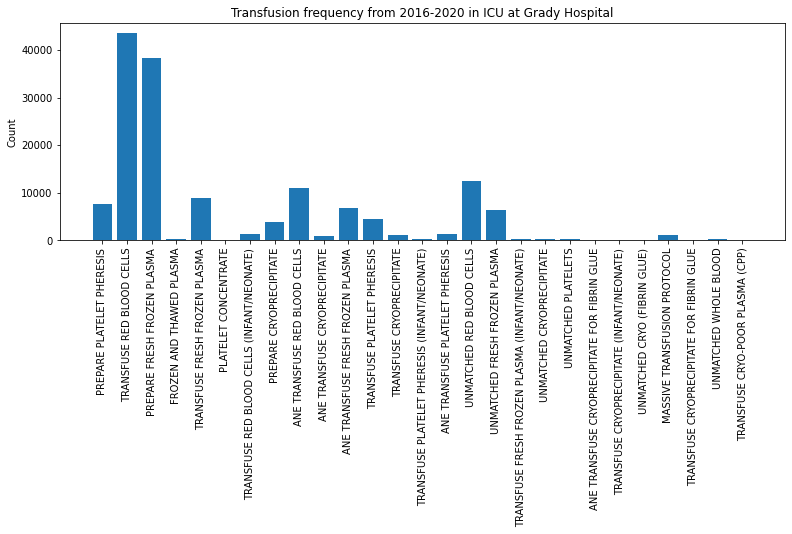

Counter({'PREPARE PLATELET PHERESIS': 7552,
         'TRANSFUSE RED BLOOD CELLS': 43474,
         'PREPARE FRESH FROZEN PLASMA': 38294,
         'FROZEN AND THAWED PLASMA': 306,
         'TRANSFUSE FRESH FROZEN PLASMA': 8870,
         'PLATELET CONCENTRATE': 73,
         'TRANSFUSE RED BLOOD CELLS (INFANT/NEONATE)': 1387,
         'PREPARE CRYOPRECIPITATE': 3822,
         'ANE TRANSFUSE RED BLOOD CELLS': 10910,
         'ANE TRANSFUSE CRYOPRECIPITATE': 876,
         'ANE TRANSFUSE FRESH FROZEN PLASMA': 6779,
         'TRANSFUSE PLATELET PHERESIS': 4587,
         'TRANSFUSE CRYOPRECIPITATE': 1215,
         'TRANSFUSE PLATELET PHERESIS (INFANT/NEONATE)': 320,
         'ANE TRANSFUSE PLATELET PHERESIS': 1292,
         'UNMATCHED RED BLOOD CELLS': 12424,
         'UNMATCHED FRESH FROZEN PLASMA': 6399,
         'TRANSFUSE FRESH FROZEN PLASMA (INFANT/NEONATE)': 403,
         'UNMATCHED CRYOPRECIPITATE': 323,
         'UNMATCHED PLATELETS': 365,
         'ANE TRANSFUSE CRYOPRECIPITATE FOR FIB

In [29]:
ww = Counter(df_transfusion_years.blood_product_name)
plt.figure(figsize=[13,4])
plt.bar(ww.keys(), ww.values())
y_pos = range(len(ww.keys()))
# Rotation of the bars names
plt.xticks(y_pos, ww.keys(), rotation=90)
plt.title('Transfusion frequency from 2016-2020 in ICU at Grady Hospital')
plt.ylabel('Count')
plt.show()
ww

### Find the matched patients

In [ ]:
df_transfusion_years.reset_index(drop=True, inplace=True)
df_transfusion_years

In [38]:
All_Vent_Pat_bed_matched_total.year = All_Vent_Pat_bed_matched_total.year.astype(int)

In [39]:
df_transfusion_years.dtypes

pat_id                        object
csn                            int64
har                          float64
mrn                            int64
study_id                     float64
order_time                    object
order_id                       int64
blood_transfusion_type        object
blood_product_name            object
unit                           int64
product_code                  object
product_status                object
transfusion_start             object
transfusion_end               object
transfusion_complete_time     object
year                           int64
dtype: object

In [40]:
All_Vent_Pat_bed_matched_total.dtypes

index                             int64
pat_id                           object
csn                               int64
har                             float64
mrn                               int64
study_id                        float64
age                             float64
zip_code                         object
ed_arrival_source                object
pre_admit_location               object
ed_presentation_time             object
hospital_admission_date_time     object
hospital_discharge_date_time     object
admit_reason                     object
insurance_status                 object
cpr_in_ed                        object
total_icu_days                  float64
total_vent_days                 float64
total_hosp_days                 float64
discharge_status                 object
discharge_to                     object
encounter_type                   object
PAT_ID                           object
year                              int64
dtype: object

In [ ]:
All_csn_transfusion = All_Vent_Pat_bed_matched_total.merge(df_transfusion_years,on='csn',how='left') #Intersection
All_csn_transfusion

In [ ]:
All_csn_transfusion[['pat_id_x', 'pat_id_y','year_x','year_y','transfusion_start']]


In [53]:
All_csn_transfusion['year'] = All_csn_transfusion['year_x']
All_csn_transfusion['pat_id'] = All_csn_transfusion['pat_id_x']
All_csn_transfusion['age_yrs'] = All_csn_transfusion['age']

In [54]:
All_csn_transfusion.columns

Index(['index', 'pat_id_x', 'csn', 'har_x', 'mrn_x', 'study_id_x', 'age',
       'zip_code', 'ed_arrival_source', 'pre_admit_location',
       'ed_presentation_time', 'hospital_admission_date_time',
       'hospital_discharge_date_time', 'admit_reason', 'insurance_status',
       'cpr_in_ed', 'total_icu_days', 'total_vent_days', 'total_hosp_days',
       'discharge_status', 'discharge_to', 'encounter_type', 'PAT_ID',
       'year_x', 'pat_id_y', 'har_y', 'mrn_y', 'study_id_y', 'order_time',
       'order_id', 'blood_transfusion_type', 'blood_product_name', 'unit',
       'product_code', 'product_status', 'transfusion_start',
       'transfusion_end', 'transfusion_complete_time', 'year_y', 'year',
       'pat_id', 'age_yrs'],
      dtype='object')

In [68]:
All_csn_transfusion_new_selColumns0 = All_csn_transfusion[['pat_id', 'csn','age_yrs',
       'transfusion_start',  'transfusion_end', 'blood_product_name','hospital_admission_date_time','hospital_discharge_date_time',
       'unit','year']] 

In [69]:
All_csn_transfusion_new_selColumns0.blood_product_name.value_counts()

PREPARE FRESH FROZEN PLASMA                       24329
TRANSFUSE RED BLOOD CELLS                         18188
UNMATCHED RED BLOOD CELLS                          7933
ANE TRANSFUSE RED BLOOD CELLS                      6298
TRANSFUSE FRESH FROZEN PLASMA                      6065
ANE TRANSFUSE FRESH FROZEN PLASMA                  4423
UNMATCHED FRESH FROZEN PLASMA                      4249
PREPARE PLATELET PHERESIS                          4249
TRANSFUSE PLATELET PHERESIS                        2510
PREPARE CRYOPRECIPITATE                            2460
ANE TRANSFUSE PLATELET PHERESIS                     822
MASSIVE TRANSFUSION PROTOCOL                        773
TRANSFUSE CRYOPRECIPITATE                           734
ANE TRANSFUSE CRYOPRECIPITATE                       548
UNMATCHED PLATELETS                                 236
UNMATCHED CRYOPRECIPITATE                           202
FROZEN AND THAWED PLASMA                            173
UNMATCHED WHOLE BLOOD                           

In [70]:
All_csn_transfusion_new_selColumns0.blood_product_name.str.contains('red', case=False) 

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
96987     True
96988    False
96989    False
96990      NaN
96991      NaN
Name: blood_product_name, Length: 96992, dtype: object

In [71]:
### Remove columns with generated Nans from merging/matching process
print(All_csn_transfusion_new_selColumns0['transfusion_start'].isnull().sum())
print(All_csn_transfusion_new_selColumns0['transfusion_end'].isnull().sum())
print(All_csn_transfusion_new_selColumns0['blood_product_name'].isnull().sum())

12631
39727
12631


In [ ]:
All_csn_transfusion_new = All_csn_transfusion_new_selColumns0[~(All_csn_transfusion_new_selColumns0['transfusion_start'].isnull())]
All_csn_transfusion_new.reset_index(drop=True, inplace=True)
All_csn_transfusion_new

In [84]:
All_csn_transfusion_new[All_csn_transfusion_new.blood_product_name == 'TRANSFUSE RED BLOOD CELLS (INFANT/NEONATE)']

,pat_id,csn,age_yrs,transfusion_start,transfusion_end,blood_product_name,hospital_admission_date_time,hospital_discharge_date_time,unit,year
35671,Z460384,1021000315,33.0,2017-09-29 13:29:00.000,2017-09-29 13:48:00.000,TRANSFUSE RED BLOOD CELLS (INFANT/NEONATE),2017-09-29 10:28:00.000,2017-10-01 21:45:00.000,1.0,2017


In [48]:
print(All_csn_transfusion_new['transfusion_start'].isnull().sum())

NameError: name 'All_csn_transfusion_new' is not defined

In [74]:
All_csn_transfusion_new['unit'].isna().sum()

0

In [77]:
# debedWavT = len(All_csn_transfusion_new_selColumns0['deBedTime'].unique())

patWavT = len(All_csn_transfusion_new['pat_id'].unique())
csnWavT = len(All_csn_transfusion_new['csn'].unique())
yrsWavT = All_csn_transfusion_new['year'].unique()
print(f'Total patients transfused-- #pat_ids: {patWavT}, #CSNs: {csnWavT},  #Years: {yrsWavT}')

Total patients transfused-- #pat_ids: 5807, #CSNs: 6131,  #Years: [2016 2017 2018 2019 2020]


In [81]:
All_csn_transfusion_new[All_csn_transfusion_new.blood_product_name.str.contains('red', case=False)].blood_product_name.value_counts()

TRANSFUSE RED BLOOD CELLS                     18188
UNMATCHED RED BLOOD CELLS                      7933
ANE TRANSFUSE RED BLOOD CELLS                  6298
TRANSFUSE RED BLOOD CELLS (INFANT/NEONATE)        1
Name: blood_product_name, dtype: int64

In [85]:
All_csn_transfusion_new[All_csn_transfusion_new.blood_product_name.str.contains('red', case=False)].blood_product_name.unique()

array(['TRANSFUSE RED BLOOD CELLS', 'ANE TRANSFUSE RED BLOOD CELLS',
       'UNMATCHED RED BLOOD CELLS',
       'TRANSFUSE RED BLOOD CELLS (INFANT/NEONATE)'], dtype=object)

In [86]:
RBC_list = ['TRANSFUSE RED BLOOD CELLS', 'ANE TRANSFUSE RED BLOOD CELLS',
       'UNMATCHED RED BLOOD CELLS',
       'TRANSFUSE RED BLOOD CELLS (INFANT/NEONATE)']

### Focus on only Red cell transfusions

In [ ]:
All_csn_transfusion_new_RBC = All_csn_transfusion_new[All_csn_transfusion_new.blood_product_name.isin(RBC_list)]
All_csn_transfusion_new_RBC

In [89]:
All_csn_transfusion_new_RBC.reset_index(drop=True, inplace=True)

## Dicarding the patients with MTP showing bleeding/traumatic conditions 
> Greater than 3 transfusions in 6 hours

> **(a) Sort dataframe by csn sothat similar csn could be grouped, (b) check for each csn, whether it has repitions >3, (c) if it has, then check the timings if all are within 6 hrs window ---> discard this csn row entries completely**

In [ ]:
All_csn_transfusion_new_RBC2 = All_csn_transfusion_new_RBC.sort_values(by=['csn'])
All_csn_transfusion_new_RBC2.reset_index(drop=True, inplace=True)
All_csn_transfusion_new_RBC2

In [91]:
MTP_csns = np.array([],dtype=int)
unique_csns = All_csn_transfusion_new_RBC2['csn'].unique()
for i in tqdm(unique_csns):
    csn_count = list(All_csn_transfusion_new_RBC2['csn']).count(i)
    if csn_count >= 3:
        #print(csn_count)
        idx = np.where(np.array(All_csn_transfusion_new_RBC2['csn'])==i)[0]
        trans_times = pd.to_datetime(All_csn_transfusion_new_RBC2['transfusion_start'].iloc[idx]) 
        trans_times_sort = trans_times.sort_values().reset_index(drop=True)
        #print(trans_times_sort)
        diff_tt_sort = trans_times_sort.diff()
        Tcount_under_6hrs = (diff_tt_sort<pd.Timedelta(hours=6)).sum()
        if Tcount_under_6hrs >= 3:
            #print('MTP patient: discard it')
            MTP_csns = np.append(MTP_csns, i)
       
      
        
    

100%|██████████| 5403/5403 [01:19<00:00, 67.65it/s]


In [100]:
len(MTP_csns)

1388

# MTP
> **Discarding MTP csns by merging**

In [92]:
MTP_csn_array=np.array([MTP_csns, MTP_csns+10000000000000]).T

In [93]:
dfMTP_csns = pd.DataFrame(MTP_csn_array, index=np.arange(len(MTP_csn_array)), columns=['csn','arbitrary'])
dfMTP_csns

,csn,arbitrary
0,1015788298,10001015788298
1,1015792003,10001015792003
2,1015794504,10001015794504
3,1015805995,10001015805995
4,1015826433,10001015826433
...,...,...
1383,1039522856,10001039522856
1384,1039704019,10001039704019
1385,1039704637,10001039704637
1386,1039723458,10001039723458


In [ ]:
All_csn_transfusion_new_RBC3 = All_csn_transfusion_new_RBC2.merge(dfMTP_csns,on='csn',how='left')#MTP_csns_series
All_csn_transfusion_new_RBC3

In [95]:
All_csn_transfusion_new_RBC3['arbitrary'].isnull()

0         True
1        False
2        False
3        False
4        False
         ...  
32415    False
32416    False
32417    False
32418    False
32419     True
Name: arbitrary, Length: 32420, dtype: bool

In [ ]:
All_csn_transfusion_new_RBC4 = All_csn_transfusion_new_RBC3[All_csn_transfusion_new_RBC3['arbitrary'].isnull()]
All_csn_transfusion_new_RBC4

In [97]:
IntersectionBeforeAfterT_RBC = All_csn_transfusion_new_RBC4

In [ ]:
IntersectionBeforeAfterT_RBC.drop_duplicates(inplace=True)
IntersectionBeforeAfterT_RBC.reset_index(drop=True, inplace=True)
IntersectionBeforeAfterT_RBC

In [101]:
#debedWavT3 = len(All_csndata_during_transfusion_list['deBedTime'].unique())
patWavT3 = len(IntersectionBeforeAfterT_RBC['pat_id'].unique())
csnWavT3 = len(IntersectionBeforeAfterT_RBC['csn'].unique())
yrsWavT3 = IntersectionBeforeAfterT_RBC['year'].unique()
print(f'Total patients having waveforms collected during transfusion-- #pat_ids: {patWavT3}, #CSNs: {csnWavT3}, #Years: {yrsWavT3}')

Total patients having waveforms collected during transfusion-- #pat_ids: 3802, #CSNs: 4015, #Years: [2016 2017 2018 2019 2020]


In [102]:
print(bedPat.shape, All_Vent_Pat_bed_matched_total.shape, df_transfusion.shape, All_csn_transfusion_new.shape, IntersectionBeforeAfterT_RBC.shape)

(82002, 21) (18763, 24) (311734, 16) (84361, 10) (10767, 11)


In [103]:
IntersectionBeforeAfterT_RBC.drop_duplicates(inplace=True)
IntersectionBeforeAfterT_RBC.shape

(10767, 11)

In [105]:
#Remove redundency
IntersectionBeforeAfterT_RBC.drop_duplicates(subset=['pat_id', 'csn','transfusion_start'], keep='first', inplace=True)

In [106]:
IntersectionBeforeAfterT_RBC.drop(['arbitrary'], axis=1, inplace=True)

In [107]:
IntersectionBeforeAfterT_RBC.shape

(10765, 10)

In [ ]:
IntersectionBeforeT_RBC_sorted = IntersectionBeforeAfterT_RBC.sort_values(by=['csn'])
IntersectionBeforeT_RBC_sorted

## Exclude RBC Transfusions followed last 24 hours for a CSN

In [ ]:
x1 = IntersectionBeforeT_RBC_sorted[['csn','transfusion_start']]
x1

In [110]:
#exclude RBC Transfusions followed last 24 hours for a CSN

valid_Transf = pd.DataFrame([],columns=['csn','transfusion_start'])
csn_uni =x1.csn.unique()
for i, csnn in tqdm(enumerate(csn_uni)):
    idx = np.where(x1.csn == csnn)[0]
    TT=pd.to_datetime(x1.iloc[idx]['transfusion_start']).sort_values()
    dTT = TT.diff().dt.days
    Tsep = dTT < 1 #Trasfusion separation less than 1 day
    Tsep.iloc[0] = False
    z = np.where(~Tsep)[0] #Indexes need to save for csns and transfusions
    a = np.array([csnn]*len(z))
    b = TT.iloc[z].values
    z1 = pd.DataFrame([a,b],index=['csn','transfusion_start']).T
    valid_Transf = pd.concat([valid_Transf, z1],ignore_index=True)


4015it [00:15, 253.62it/s]


In [112]:
valid_Transf['Arb'] = 50
valid_Transf['csn'] = valid_Transf['csn'].astype(int)
valid_Transf['transfusion_start'] = pd.to_datetime(valid_Transf['transfusion_start'])

In [ ]:
IntersectionBeforeT_RBC_sorted['csn'] = IntersectionBeforeT_RBC_sorted['csn'].astype(int)
IntersectionBeforeT_RBC_sorted['transfusion_start'] = pd.to_datetime(IntersectionBeforeT_RBC_sorted['transfusion_start'])
IntersectionBeforeT_RBC_sorted1 = pd.merge(IntersectionBeforeT_RBC_sorted, valid_Transf, on=['csn','transfusion_start'],how='left')
IntersectionBeforeT_RBC_sorted2 = IntersectionBeforeT_RBC_sorted1[~IntersectionBeforeT_RBC_sorted1['Arb'].isnull()]
IntersectionBeforeT_RBC_sorted2.drop_duplicates(inplace=True)
IntersectionBeforeT_RBC_sorted2.reset_index(drop=True, inplace=True)
IntersectionBeforeT_RBC_sorted2

In [114]:
IntersectionBeforeT_RBC_sorted2.shape

(6894, 11)

## Add count of all product transfusions as a feature column in last 7 days

In [ ]:
all_transfusions = All_csn_transfusion_new[['csn','transfusion_start','blood_product_name']]
all_transfusions['transfusion_start'] = pd.to_datetime(all_transfusions['transfusion_start'])
all_transfusions['arbbb'] = 1000
all_transfusions.drop_duplicates(inplace=True)
all_transfusions.reset_index(drop=True, inplace=True)
all_transfusions

In [125]:
IntersectionBeforeT_RBC_sorted2['Tcount_7d'] = np.nan
for i in tqdm(range(IntersectionBeforeT_RBC_sorted2.shape[0])):
    est_TT =  IntersectionBeforeT_RBC_sorted2.iloc[i].transfusion_start
    csnn = IntersectionBeforeT_RBC_sorted2.iloc[i].csn
    
    all_TT_csnn = all_transfusions[all_transfusions.csn==csnn].transfusion_start
    Tdiff = est_TT - all_TT_csnn
    # Tdiffd = Tdiff.dt.days
    cond1 =  Tdiff>pd.Timedelta('0 days 00:00:00') 
    cond2 = Tdiff<pd.Timedelta('7 days 00:00:00')
    Tcount1 = (cond1 & cond2).sum()
    IntersectionBeforeT_RBC_sorted2['Tcount_7d'].iloc[i] = Tcount1
    
IntersectionBeforeT_RBC_sorted2['Tcount_7d'].isnull().sum()    
    
    

100%|██████████| 6894/6894 [02:46<00:00, 41.37it/s]


0

In [122]:
# est_TT 
# all_TT_csnn

1190    2016-01-01 01:51:00.000
1191    2016-01-01 01:52:00.000
1192    2016-01-01 02:34:00.000
1193    2016-01-01 06:14:00.000
1194    2016-01-04 11:25:00.000
Name: transfusion_start, dtype: object

In [ ]:
IntersectionBeforeT_RBC_sorted2

In [127]:
IntersectionBeforeT_RBC_sorted2['year'] = IntersectionBeforeT_RBC_sorted2['year'].astype(int)

# Checkpoint 1: Save CSV

In [49]:
# IntersectionBeforeT_RBC_sorted2.to_csv('DATA_RESULTS/df_GRADY_RBCT_beforeFeat_extraction_v3.csv')





# IntersectionBeforeT_RBC_sorted2 = pd.read_csv('DATA_RESULTS/df_GRADY_RBCT_beforeFeat_extraction_v3.csv')

In [9]:
''' **Designed for GRADY data** 
Assumptions are: (i) T: Transfusion time = 4 hrs
Before T: 3-24 hrs
After T: T+4 to T+4+tau hrs, where tau = 9 
Include baseline Hb (as variable) just before the transfusion started'''


def vitalsign_feature_extract(csn, year, transT, tau, row_index): #tau = 6 # (in hrs, duration for three afterT segments) 3, 6, 9, 12, 24 for 3 consecutive windows
    
    #AllFeatureTable = pd.DataFrame([])


    ## Assessing super table
    pkl_path = '/labs/kamaleswaranlab/MODS/Encounter_Pickles/gr/'+str(year)+'/'+str(csn)+'.pickle'
    with open(pkl_path, 'rb') as pf:
        patient_enc_dict = pickle.load(pf)
    super_table = patient_enc_dict['super_table']
    super_table['Time']=super_table.index
    
    super_table0 = super_table.pop('Time')
    super_table.insert(0, 'Time', super_table0) #First column is "Time" now [moved from last to first column]
    
    
    super_table.index=np.arange(len(super_table))
    super_table.replace([np.inf, -np.inf], np.nan, inplace=True)
    #super_table.dropna(subset=super_table.iloc[:,1:].columns, how="all", inplace=True)
    
    super_table.fio2.loc[super_table.fio2<0.21]=0.21

    # SF_ratio = super_table['pf_sp']
    hemogb = super_table['hemoglobin']
    # PF_ratio = super_table['pf_pa']
    spo2 = super_table['spo2']
    fio2 = super_table['fio2']
    pao2 = super_table['partial_pressure_of_oxygen_(pao2)']

    if fio2.isnull().all():
        fio2 = 0.21
    else:
        fio2.fillna(method='ffill', limit=24, inplace=True)
        fio2.fillna(method='bfill', limit=24, inplace=True) 
        
    SF_ratio = spo2/fio2
    PF_ratio = pao2/fio2
    
    # super_table.replace([np.inf, -np.inf], np.nan, inplace=True)
    # super_table.dropna(subset=super_table.iloc[:,1:].columns, how="all", inplace=True)
    
    
    #Get these measures for beforeT and afterT segments
    a = np.array((transT-super_table['Time']).dt.days)
    
    #Find the sign change to identify transfusion time
    id1=np.where(a>=0)
    beforeTid = id1[0][-1] #it will throw indexError if id1 is empty 
    id2=np.where(a<0)
    afterTid = id2[0][0] + 4  #Considering 4 hrs of transfusion duration
    
    #Inter-sample interval is 1 hr in super_table
    if beforeTid >= 23: 
        beforeT_Inds = np.arange(beforeTid-23, beforeTid+1)
        Hb_beforeT0 = hemogb[beforeT_Inds]
        SF_beforeT0 = SF_ratio[beforeT_Inds]
        PF_beforeT0 = PF_ratio[beforeT_Inds]
        spo2_beforeT0 = spo2[beforeT_Inds]

#         #Removal of NAN entries
        Hb_beforeT = Hb_beforeT0[~Hb_beforeT0.isnull()]      #Hb_beforeT0[np.logical_not(np.isnan(Hb_beforeT0))]
#         SF_beforeT = SF_beforeT0[~SF_beforeT0.isnull()] 
#         PF_beforeT = PF_beforeT0[~PF_beforeT0.isnull()] 
#         spo2_beforeT = spo2_beforeT0[~spo2_beforeT0.isnull()] 
        
        med_Hb_beforeT = Hb_beforeT0.median() #np.median(Hb_beforeT)
        med_SF_beforeT = SF_beforeT0.median()
        med_PF_beforeT = PF_beforeT0.median()
        med_spo2_beforeT = spo2_beforeT0.median()
        # print(('loop if '+str(row_index)+'->'+str(np.array(Hb_beforeT0))))
        if Hb_beforeT.empty:
            Hb = np.nan   ### Baseline Hb just before the transfusion started 
        else:
            Hb = np.array(Hb_beforeT)[-1]   ### Baseline Hb just before the transfusion started 
        #print(SF_beforeT0) 
        #print(Hb_beforeT)
        # print(('loop if '+str(row_index)))

        my_table_BeforeT = pd.DataFrame({'Hb':Hb, 'med_spo2_beforeT':med_spo2_beforeT, 'med_Hb_beforeT':med_Hb_beforeT, \
                                         'med_SF_beforeT':med_SF_beforeT, 'med_PF_beforeT':med_PF_beforeT}, index=[0])
        #my_table_BeforeT.reset_index(drop=True, inplace=True)
    elif beforeTid > 2 and beforeTid < 23: 
        # print(('loop elif'+str(row_index)))
        beforeT_Inds = np.arange(0, beforeTid+1)
        Hb_beforeT0 = hemogb[beforeT_Inds]
        SF_beforeT0 = SF_ratio[beforeT_Inds]
        PF_beforeT0 = PF_ratio[beforeT_Inds]
        spo2_beforeT0 = spo2[beforeT_Inds]
        
        #Removal of NAN entries
        Hb_beforeT = Hb_beforeT0[~Hb_beforeT0.isnull()]      #Hb_beforeT0[np.logical_not(np.isnan(Hb_beforeT0))]
#         SF_beforeT = SF_beforeT0[~SF_beforeT0.isnull()] 
#         PF_beforeT = PF_beforeT0[~PF_beforeT0.isnull()] 
#         spo2_beforeT = spo2_beforeT0[~spo2_beforeT0.isnull()] 

        med_Hb_beforeT = Hb_beforeT0.median() #np.median(Hb_beforeT)
        med_SF_beforeT = SF_beforeT0.median()
        med_PF_beforeT = PF_beforeT0.median()
        med_spo2_beforeT = spo2_beforeT0.median()
        if Hb_beforeT.empty:
            Hb = np.nan   ### Baseline Hb just before the transfusion started 
        else:
            Hb = np.array(Hb_beforeT)[-1]   ### Baseline Hb just before the transfusion started 

        
        #print(SF_beforeT0)         
        #print(Hb_beforeT)

        my_table_BeforeT = pd.DataFrame({'Hb':Hb, 'med_spo2_beforeT':med_spo2_beforeT, 'med_Hb_beforeT':med_Hb_beforeT, \
                                         'med_SF_beforeT':med_SF_beforeT, 'med_PF_beforeT':med_PF_beforeT}, index=[0])                         
        #my_table_BeforeT.reset_index(drop=True, inplace=True)  
    else:
        my_table_BeforeT = []
        #print('Removed')
        # print(('loop else'+str(row_index)))
 
    #####-----------------------------------------
     
    

    med_Hb_afterT = []
    med_SF_afterT = []
    med_PF_afterT = []
    med_spo2_afterT = []
    for tauId in range(3):
        if afterTid+((tauId+1)*tau) <= len(hemogb): # for total tau hrs range post-transfusion
            #print('flag1') 
            afterT_Inds = np.arange(afterTid+(tauId*tau), afterTid+((tauId+1)*tau))
            Hb_afterT0 = hemogb[afterT_Inds]
            SF_afterT0 = SF_ratio[afterT_Inds]
            PF_afterT0 = PF_ratio[afterT_Inds]
            spo2_afterT0 = spo2[afterT_Inds]
            
            

            #Removal of NAN entries
#             Hb_afterT = Hb_beforeT0[~Hb_beforeT0.isnull()]               #Hb_afterT0[np.logical_not(np.isnan(Hb_afterT0))]
#             SF_afterT = SF_afterT0[np.logical_not(np.isnan(SF_afterT0))]
#             PF_afterT = PF_afterT0[np.logical_not(np.isnan(PF_afterT0))]
#             spo2_afterT = spo2_afterT0[np.logical_not(np.isnan(spo2_afterT0))]            

            med_Hb_afterT.append(Hb_afterT0.median())    #med_Hb_afterT.append(np.median(Hb_afterT))
            med_SF_afterT.append(SF_afterT0.median())
            med_PF_afterT.append(PF_afterT0.median())
            med_spo2_afterT.append(spo2_afterT0.median())
            
        elif afterTid+((tauId+1)*tau) > len(hemogb) and afterTid+((tauId+1)*tau) <= len(hemogb)-3: # for atleast having 3 hrs range post-transfusion
            #print('flag2')
            afterT_Inds = np.arange(afterTid+(tauId*tau), len(hemogb))
            Hb_afterT0 = hemogb[afterT_Inds]
            SF_afterT0 = SF_ratio[afterT_Inds]
            PF_afterT0 = PF_ratio[afterT_Inds]
            spo2_afterT0 = spo2[afterT_Inds]
            
             

#             #Removal of NAN entries
#             Hb_afterT = Hb_afterT0[np.logical_not(np.isnan(Hb_afterT0))]
#             SF_afterT = SF_afterT0[np.logical_not(np.isnan(SF_afterT0))]
#             PF_afterT = PF_afterT0[np.logical_not(np.isnan(PF_afterT0))]
#             spo2_afterT = spo2_afterT0[np.logical_not(np.isnan(spo2_afterT0))]            

            med_Hb_afterT.append(Hb_afterT0.median())    #med_Hb_afterT.append(np.median(Hb_afterT))
            med_SF_afterT.append(SF_afterT0.median())
            med_PF_afterT.append(PF_afterT0.median())
            med_spo2_afterT.append(spo2_afterT0.median())
            
        else:
            med_Hb_afterT.append(None)
            med_SF_afterT.append(None)
            med_PF_afterT.append(None)
            med_spo2_afterT.append(None)
            
        
        
       
    
    ######-------------------------------------
        
#     # Tracking missing data at the output (Trying to find the reason of csns reduction after this fun executed)
#     csn_yr_Ttime = str(csn)+'/'+str(year)+'/'+str(transT)
#     if len(my_table_BeforeT) == 0: 
#         BeforeT_no3hrsdata = csn_yr_Ttime
#     else: 
#         BeforeT_no3hrsdata = 0
#         if pd.isnull(med_Hb_beforeT): med_Hb_beforeT_missing=csn_yr_Ttime
#         else: med_Hb_beforeT_missing = 0

#         if pd.isnull(med_spo2_beforeT): med_spo2_beforeT_missing=csn_yr_Ttime 
#         else: med_spo2_beforeT_missing = 0

#         if pd.isnull(med_SF_beforeT): med_SF_beforeT_missing=csn_yr_Ttime 
#         else: med_SF_beforeT_missing = 0

#         if pd.isnull(med_PF_beforeT): med_PF_beforeT_missing=csn_yr_Ttime 
#         else: med_PF_beforeT_missing = 0

    
#     if all(pd.isnull(med_Hb_afterT)): med_Hb_afterT_all3missing=csn_yr_Ttime 
#     else: med_Hb_afterT_all3missing = 0
    
#     if all(pd.isnull(med_spo2_afterT)): med_spo2_afterT_all3missing=csn_yr_Ttime 
#     else: med_spo2_afterT_all3missing = 0
    
#     if all(pd.isnull(med_SF_afterT)): med_SF_afterT_all3missing=csn_yr_Ttime 
#     else: med_SF_afterT_all3missing = 0
    
#     if all(pd.isnull(med_PF_afterT)): med_PF_afterT_all3missing=csn_yr_Ttime
#     else: med_PF_afterT_all3missing = 0    
    
    
    #Discarding patient with no data present beforeT 3hrs window
    #and Discarding patient if all afterT features are empty (None/NaN) 
    Ls = len(my_table_BeforeT)
    if Ls>0: #and (not pd.isnull(med_Hb_beforeT)) and (not pd.isnull(med_spo2_beforeT)) and (not pd.isnull(med_SF_beforeT)) and (not pd.isnull(med_PF_beforeT)) and (not all(pd.isnull(med_Hb_afterT))) and (not all(pd.isnull(med_spo2_afterT))) and (not all(pd.isnull(med_SF_afterT))) and (not all(pd.isnull(med_PF_afterT))): 
        z = pd.DataFrame(IntersectionBeforeT_RBC_sorted2.iloc[row_index]).T
        z['discharge_to'] = patient_enc_dict['static_features']['discharge_to']
        z['age'] = patient_enc_dict['static_features']['age']
        z['gender'] = patient_enc_dict['static_features']['gender']
        z['race'] = patient_enc_dict['static_features']['race']
        z['ethnicity'] = patient_enc_dict['static_features']['ethnicity'] 
                
        z.reset_index(drop=True, inplace=True)
        my_table_BeforeT.reset_index(drop=True, inplace=True)
        my_table_BeforeT1 = pd.concat([z, my_table_BeforeT], axis=1)
        
        MSPO2_afterT1, MSPO2_afterT2, MSPO2_afterT3 = med_spo2_afterT
        MHB_afterT1, MHB_afterT2, MHB_afterT3 = med_Hb_afterT
        MSF_afterT1, MSF_afterT2, MSF_afterT3 = med_SF_afterT
        MPF_afterT1, MPF_afterT2, MPF_afterT3 = med_PF_afterT
        my_table_AfterT = pd.DataFrame({'MSPO2_afterT1':MSPO2_afterT1, 'MSPO2_afterT2':MSPO2_afterT2, 'MSPO2_afterT3': MSPO2_afterT3,
                                        'MHB_afterT1':MHB_afterT1, 'MHB_afterT2':MHB_afterT2, 'MHB_afterT3': MHB_afterT3,
                                        'MSF_afterT1':MSF_afterT1, 'MSF_afterT2':MSF_afterT2, 'MSF_afterT3': MSF_afterT3,
                                        'MPF_afterT1':MPF_afterT1, 'MPF_afterT2':MPF_afterT2, 'MPF_afterT3': MPF_afterT3
                                       }, index=[0])                         
        my_table_BeforeT1.reset_index(drop=True, inplace=True)
        my_table_AfterT.reset_index(drop=True, inplace=True)
        my_table_BeforeAfterT = pd.concat([my_table_BeforeT1, my_table_AfterT], axis=1)

        #AllFeatureTable = AllFeatureTable.append(my_table_BeforeAfterT)
        total_eleminated = 0
    else:
        my_table_BeforeAfterT = []
        #total_eleminated = csn_yr_Ttime
        
        
    
    # missingD = pd.DataFrame({'total_eleminated':total_eleminated, 'BeforeT_no3hrsdata': BeforeT_no3hrsdata,
    #                          'med_Hb_beforeT_missing': med_Hb_beforeT_missing})

    return my_table_BeforeAfterT #, missingD
        # Hb, med_spo2_beforeT,\
        # med_Hb_beforeT, med_SF_beforeT, med_PF_beforeT, med_spo2_afterT, med_Hb_afterT, med_SF_afterT, med_PF_afterT


In [ ]:
# ''' **Designed for EMORY data** 
# Assumptions are: (i) T: Transfusion time = 4 hrs
# Before T: 3-24 hrs
# After T: T+4 to T+4+tau hrs, where tau = 9 
# Include baseline Hb (as variable) just before the transfusion started'''


# def vitalsign_feature_extract(csn, year, transT, tau, row_index): #tau = 6 # (in hrs, duration for three afterT segments) 3, 6, 9, 12, 24 for 3 consecutive windows
    
#     #AllFeatureTable = pd.DataFrame([])


#     ## Assessing super table
#     pkl_path = '/labs/kamaleswaranlab/MODS/Encounter_Pickles/em/'+str(year)+'/'+str(csn)+'.pickle'
#     with open(pkl_path, 'rb') as pf:
#         patient_enc_dict = pickle.load(pf)
#     super_table = patient_enc_dict['super_table']
#     super_table['Time']=super_table.index
    
#     super_table0 = super_table.pop('Time')
#     super_table.insert(0, 'Time', super_table0) #First column is "Time" now [moved from last to first column]
    
#     super_table.index=np.arange(len(super_table))
#     super_table.replace([np.inf, -np.inf], np.nan, inplace=True)
#     #super_table.dropna(subset=super_table.iloc[:,1:].columns, how="all", inplace=True)

#     SF_ratio = super_table['pf_sp']
#     hemogb = super_table['hemoglobin']
#     PF_ratio = super_table['pf_pa']
#     spo2 = super_table['spo2']

#     #Get these measures for beforeT and afterT segments
#     a = np.array((transT-super_table['Time']).dt.days)
    

#     #Find the sign change to identify transfusion time
#     id1=np.where(a>=0)
#     beforeTid = id1[0][-1]
#     id2=np.where(a<0)
#     afterTid = id2[0][0] + 4  #Considering 4 hrs of transfusion duration
    
#     #Inter-sample interval is 1 hr in super_table
#     if beforeTid >= 23: 
#         beforeT_Inds = np.arange(beforeTid-23, beforeTid+1)
#         Hb_beforeT0 = hemogb[beforeT_Inds]
#         SF_beforeT0 = SF_ratio[beforeT_Inds]
#         PF_beforeT0 = PF_ratio[beforeT_Inds]
#         spo2_beforeT0 = spo2[beforeT_Inds]

# #         #Removal of NAN entries
#         Hb_beforeT = Hb_beforeT0[~Hb_beforeT0.isnull()]      #Hb_beforeT0[np.logical_not(np.isnan(Hb_beforeT0))]
# #         SF_beforeT = SF_beforeT0[~SF_beforeT0.isnull()] 
# #         PF_beforeT = PF_beforeT0[~PF_beforeT0.isnull()] 
# #         spo2_beforeT = spo2_beforeT0[~spo2_beforeT0.isnull()] 

#         med_Hb_beforeT = Hb_beforeT0.median() #np.median(Hb_beforeT)
#         med_SF_beforeT = SF_beforeT0.median()
#         med_PF_beforeT = PF_beforeT0.median()
#         med_spo2_beforeT = spo2_beforeT0.median()
#         Hb = np.array(Hb_beforeT)[-1]   ### Baseline Hb just before the transfusion started 
#         #print(SF_beforeT0) 
        
#         #print(Hb_beforeT)

#         my_table_BeforeT = pd.DataFrame({'Hb':Hb, 'med_spo2_beforeT':med_spo2_beforeT, 'med_Hb_beforeT':med_Hb_beforeT, \
#                                          'med_SF_beforeT':med_SF_beforeT, 'med_PF_beforeT':med_PF_beforeT}, index=[0])
#         #my_table_BeforeT.reset_index(drop=True, inplace=True)
#     elif beforeTid > 2 and beforeTid < 23: 
#         beforeT_Inds = np.arange(0, beforeTid+1)
#         Hb_beforeT0 = hemogb[beforeT_Inds]
#         SF_beforeT0 = SF_ratio[beforeT_Inds]
#         PF_beforeT0 = PF_ratio[beforeT_Inds]
#         spo2_beforeT0 = spo2[beforeT_Inds]
        
#         #Removal of NAN entries
#         Hb_beforeT = Hb_beforeT0[~Hb_beforeT0.isnull()]      #Hb_beforeT0[np.logical_not(np.isnan(Hb_beforeT0))]
# #         SF_beforeT = SF_beforeT0[~SF_beforeT0.isnull()] 
# #         PF_beforeT = PF_beforeT0[~PF_beforeT0.isnull()] 
# #         spo2_beforeT = spo2_beforeT0[~spo2_beforeT0.isnull()] 

#         med_Hb_beforeT = Hb_beforeT0.median() #np.median(Hb_beforeT)
#         med_SF_beforeT = SF_beforeT0.median()
#         med_PF_beforeT = PF_beforeT0.median()
#         med_spo2_beforeT = spo2_beforeT0.median()
#         Hb = np.array(Hb_beforeT)[-1]   ### Baseline Hb just before the transfusion started 

        
#         #print(SF_beforeT0) 
        
#         #print(Hb_beforeT)

#         my_table_BeforeT = pd.DataFrame({'Hb':Hb, 'med_spo2_beforeT':med_spo2_beforeT, 'med_Hb_beforeT':med_Hb_beforeT, \
#                                          'med_SF_beforeT':med_SF_beforeT, 'med_PF_beforeT':med_PF_beforeT}, index=[0])                         
#         #my_table_BeforeT.reset_index(drop=True, inplace=True)                                 
#     else:
#         my_table_BeforeT = []
#         #print('Removed')
 
#     #####-----------------------------------------
     
   

#     med_Hb_afterT = []
#     med_SF_afterT = []
#     med_PF_afterT = []
#     med_spo2_afterT = []
#     for tauId in range(3):
#         if afterTid+((tauId+1)*tau) <= len(hemogb): # for total tau hrs range post-transfusion
#             #print('flag1') 
#             afterT_Inds = np.arange(afterTid+(tauId*tau), afterTid+((tauId+1)*tau))
#             Hb_afterT0 = hemogb[afterT_Inds]
#             SF_afterT0 = SF_ratio[afterT_Inds]
#             PF_afterT0 = PF_ratio[afterT_Inds]
#             spo2_afterT0 = spo2[afterT_Inds]
            
            

#             #Removal of NAN entries
# #             Hb_afterT = Hb_beforeT0[~Hb_beforeT0.isnull()]               #Hb_afterT0[np.logical_not(np.isnan(Hb_afterT0))]
# #             SF_afterT = SF_afterT0[np.logical_not(np.isnan(SF_afterT0))]
# #             PF_afterT = PF_afterT0[np.logical_not(np.isnan(PF_afterT0))]
# #             spo2_afterT = spo2_afterT0[np.logical_not(np.isnan(spo2_afterT0))]            

#             med_Hb_afterT.append(Hb_afterT0.median())    #med_Hb_afterT.append(np.median(Hb_afterT))
#             med_SF_afterT.append(SF_afterT0.median())
#             med_PF_afterT.append(PF_afterT0.median())
#             med_spo2_afterT.append(spo2_afterT0.median())
            
#         elif afterTid+((tauId+1)*tau) > len(hemogb) and afterTid+((tauId+1)*tau) <= len(hemogb)-3: # for atleast having 3 hrs range post-transfusion
#             #print('flag2')
#             afterT_Inds = np.arange(afterTid+(tauId*tau), len(hemogb))
#             Hb_afterT0 = hemogb[afterT_Inds]
#             SF_afterT0 = SF_ratio[afterT_Inds]
#             PF_afterT0 = PF_ratio[afterT_Inds]
#             spo2_afterT0 = spo2[afterT_Inds]
            
             

# #             #Removal of NAN entries
# #             Hb_afterT = Hb_afterT0[np.logical_not(np.isnan(Hb_afterT0))]
# #             SF_afterT = SF_afterT0[np.logical_not(np.isnan(SF_afterT0))]
# #             PF_afterT = PF_afterT0[np.logical_not(np.isnan(PF_afterT0))]
# #             spo2_afterT = spo2_afterT0[np.logical_not(np.isnan(spo2_afterT0))]            

#             med_Hb_afterT.append(Hb_afterT0.median())    #med_Hb_afterT.append(np.median(Hb_afterT))
#             med_SF_afterT.append(SF_afterT0.median())
#             med_PF_afterT.append(PF_afterT0.median())
#             med_spo2_afterT.append(spo2_afterT0.median())
            
#         else:
#             med_Hb_afterT.append(None)
#             med_SF_afterT.append(None)
#             med_PF_afterT.append(None)
#             med_spo2_afterT.append(None)
            
        
        
       
    
#     ######-------------------------------------
        
# #     # Tracking missing data at the output (Trying to find the reason of csns reduction after this fun executed)
# #     csn_yr_Ttime = str(csn)+'/'+str(year)+'/'+str(transT)
# #     if len(my_table_BeforeT) == 0: 
# #         BeforeT_no3hrsdata = csn_yr_Ttime
# #     else: 
# #         BeforeT_no3hrsdata = 0
# #         if pd.isnull(med_Hb_beforeT): med_Hb_beforeT_missing=csn_yr_Ttime
# #         else: med_Hb_beforeT_missing = 0

# #         if pd.isnull(med_spo2_beforeT): med_spo2_beforeT_missing=csn_yr_Ttime 
# #         else: med_spo2_beforeT_missing = 0

# #         if pd.isnull(med_SF_beforeT): med_SF_beforeT_missing=csn_yr_Ttime 
# #         else: med_SF_beforeT_missing = 0

# #         if pd.isnull(med_PF_beforeT): med_PF_beforeT_missing=csn_yr_Ttime 
# #         else: med_PF_beforeT_missing = 0

    
# #     if all(pd.isnull(med_Hb_afterT)): med_Hb_afterT_all3missing=csn_yr_Ttime 
# #     else: med_Hb_afterT_all3missing = 0
    
# #     if all(pd.isnull(med_spo2_afterT)): med_spo2_afterT_all3missing=csn_yr_Ttime 
# #     else: med_spo2_afterT_all3missing = 0
    
# #     if all(pd.isnull(med_SF_afterT)): med_SF_afterT_all3missing=csn_yr_Ttime 
# #     else: med_SF_afterT_all3missing = 0
    
# #     if all(pd.isnull(med_PF_afterT)): med_PF_afterT_all3missing=csn_yr_Ttime
# #     else: med_PF_afterT_all3missing = 0    
    
    
#     #Discarding patient with no data present beforeT 3hrs window
#     #and Discarding patient if all afterT features are empty (None/NaN) 
#     Ls = len(my_table_BeforeT)
#     if Ls>0 and (not pd.isnull(med_Hb_beforeT)) and (not pd.isnull(med_spo2_beforeT)) and (not pd.isnull(med_SF_beforeT)) and (not pd.isnull(med_PF_beforeT)) and (not all(pd.isnull(med_Hb_afterT))) and (not all(pd.isnull(med_spo2_afterT))) and (not all(pd.isnull(med_SF_afterT))) and (not all(pd.isnull(med_PF_afterT))): 
#         z = pd.DataFrame(IntersectionBeforeT_RBC_sorted2.iloc[row_index]).T
#         z['discharge_to'] = patient_enc_dict['static_features']['discharge_to']
#         z['age'] = patient_enc_dict['static_features']['age']
#         z['gender'] = patient_enc_dict['static_features']['gender']
#         z['race'] = patient_enc_dict['static_features']['race']
#         z['ethnicity'] = patient_enc_dict['static_features']['ethnicity'] 
                
#         z.reset_index(drop=True, inplace=True)
#         my_table_BeforeT.reset_index(drop=True, inplace=True)
#         my_table_BeforeT1 = pd.concat([z, my_table_BeforeT], axis=1)
        
#         MSPO2_afterT1, MSPO2_afterT2, MSPO2_afterT3 = med_spo2_afterT
#         MHB_afterT1, MHB_afterT2, MHB_afterT3 = med_Hb_afterT
#         MSF_afterT1, MSF_afterT2, MSF_afterT3 = med_SF_afterT
#         MPF_afterT1, MPF_afterT2, MPF_afterT3 = med_PF_afterT
#         my_table_AfterT = pd.DataFrame({'MSPO2_afterT1':MSPO2_afterT1, 'MSPO2_afterT2':MSPO2_afterT2, 'MSPO2_afterT3': MSPO2_afterT3,
#                                         'MHB_afterT1':MHB_afterT1, 'MHB_afterT2':MHB_afterT2, 'MHB_afterT3': MHB_afterT3,
#                                         'MSF_afterT1':MSF_afterT1, 'MSF_afterT2':MSF_afterT2, 'MSF_afterT3': MSF_afterT3,
#                                         'MPF_afterT1':MPF_afterT1, 'MPF_afterT2':MPF_afterT2, 'MPF_afterT3': MPF_afterT3
#                                        }, index=[0])                         
#         my_table_BeforeT1.reset_index(drop=True, inplace=True)
#         my_table_AfterT.reset_index(drop=True, inplace=True)
#         my_table_BeforeAfterT = pd.concat([my_table_BeforeT1, my_table_AfterT], axis=1)

#         #AllFeatureTable = AllFeatureTable.append(my_table_BeforeAfterT)
#         total_eleminated = 0
#     else:
#         my_table_BeforeAfterT = []
#         #total_eleminated = csn_yr_Ttime
        
        
    
#     # missingD = pd.DataFrame({'total_eleminated':total_eleminated, 'BeforeT_no3hrsdata': BeforeT_no3hrsdata,
#     #                          'med_Hb_beforeT_missing': med_Hb_beforeT_missing})

#     return my_table_BeforeAfterT #, missingD
#         # Hb, med_spo2_beforeT,\
#         # med_Hb_beforeT, med_SF_beforeT, med_PF_beforeT, med_spo2_afterT, med_Hb_afterT, med_SF_afterT, med_PF_afterT


In [10]:
tau = 9 #int(input('Enter tau = ')) #(in hrs, duration for three afterT segments) 3, 6, 9, 12, 24 for three consecutive windows

L = len(IntersectionBeforeT_RBC_sorted2)
print(L)

6894


In [12]:
##Using Parallelization: Multiprocessing

t1 = time.time()
def f1(i):
    #for i,csn in tqdm(enumerate(IntersectionBeforeDuringAfter_RBC['csn'] )):  #.iloc[:3]
    AllFeatureTable = pd.DataFrame([])
    missingdata = pd.DataFrame([])
    try: 
        transT = pd.to_datetime(IntersectionBeforeT_RBC_sorted2.iloc[i]['transfusion_start'])
        year = pd.to_datetime(IntersectionBeforeT_RBC_sorted2.iloc[i]['transfusion_start']).year #dt.year
        csn = IntersectionBeforeT_RBC_sorted2.iloc[i]['csn']
        

        my_table_BeforeAfterT = vitalsign_feature_extract(csn, year, transT, tau, row_index=i) #, missingD
        #print(AllFeatureTable)
        
        # print(('try '+str(i)))
        
        AllFeatureTable = AllFeatureTable.append(my_table_BeforeAfterT)
        #missingdata.append(missingD)
            
    except IndexError:
        # print(('IndexError '+str(i)))
        pass
        #IndexErrorCases.append(i) #Record number
    except ValueError:
        # print(('ValueError '+str(i)))
        pass
        #ValueErrorCases.append(i)
    except FileNotFoundError:
        # print(('FileNotFoundError '+str(i)))
        pass
    except EOFError:
        print(('EOFerror '+str(i)))
        pass
        #FileNotFoundErrorCases.append(i)
    except pickle.UnpicklingError:
        print(('UnpicklingError '+str(i)))
        pass
    # except TypeError:
    #     print('TypeError')
    #     pass
    
    return AllFeatureTable #, missingdata


p1 = Pool(12)

# LLL=[0, 1, 2, 3, 4, 5, 19679, 18067, 19189, 20703]
results1 = p1.map(f1, range(L))  #range(L)
# results1, DF2 = zip(*p1.map(f1, range(10)))  #range(L)
p1.close()
p1.join()        
medianAllFeatureTable = pd.concat(results1, ignore_index=True)
# missing_Data = pd.concat(DF2, ignore_index=True)
t2 = time.time()
print('Completed in: %s sec'%(t2 - t1)) 


Completed in: 90.8263647556305 sec


In [ ]:
medianAllFeatureTable

# Checkpoint 2: Save CSV

In [16]:
# medianAllFeatureTable.to_csv('DATA_RESULTS/df_GRADY_RBCT_extractedFeat_NoImputation_tau9_v3.csv')







# medianAllFeatureTable = pd.read_csv('DATA_RESULTS/df_GRADY_RBCT_extractedFeat_NoImputation_tau9_v3.csv')

In [17]:
medianAllFeatureTable.loc[:,'Hb':].isnull().sum()

Hb                    21
med_spo2_beforeT       6
med_Hb_beforeT        21
med_SF_beforeT       909
med_PF_beforeT      3267
MSPO2_afterT1         94
MSPO2_afterT2        189
MSPO2_afterT3        296
MHB_afterT1          113
MHB_afterT2          217
MHB_afterT3          331
MSF_afterT1         1005
MSF_afterT2         1060
MSF_afterT3         1169
MPF_afterT1         3436
MPF_afterT2         3511
MPF_afterT3         3708
dtype: int64

In [18]:
medianAllFeatureTable.dtypes

Unnamed: 0                       object
pat_id                           object
csn                              object
age_yrs                          object
transfusion_start                object
transfusion_end                  object
blood_product_name               object
hospital_admission_date_time     object
hospital_discharge_date_time     object
unit                             object
year                             object
Arb                              object
Tcount_7d                        object
discharge_to                     object
age                             float64
gender                           object
race                             object
ethnicity                        object
Hb                              float64
med_spo2_beforeT                float64
med_Hb_beforeT                  float64
med_SF_beforeT                  float64
med_PF_beforeT                  float64
MSPO2_afterT1                    object
MSPO2_afterT2                    object


In [19]:
# del medianAllFeatureTable

In [20]:
'''
Missing values (%)
'''
for i in medianAllFeatureTable.columns:
    print(i, medianAllFeatureTable[i].isnull().sum()) #/medianAllFeatureTable.shape[0]*100)

Unnamed: 0 0
pat_id 0
csn 0
age_yrs 0
transfusion_start 0
transfusion_end 410
blood_product_name 0
hospital_admission_date_time 0
hospital_discharge_date_time 0
unit 0
year 0
Arb 0
Tcount_7d 0
discharge_to 5689
age 0
gender 0
race 0
ethnicity 0
Hb 21
med_spo2_beforeT 6
med_Hb_beforeT 21
med_SF_beforeT 909
med_PF_beforeT 3267
MSPO2_afterT1 94
MSPO2_afterT2 189
MSPO2_afterT3 296
MHB_afterT1 113
MHB_afterT2 217
MHB_afterT3 331
MSF_afterT1 1005
MSF_afterT2 1060
MSF_afterT3 1169
MPF_afterT1 3436
MPF_afterT2 3511
MPF_afterT3 3708


In [21]:
# fio2.fillna(method='ffill', limit=24, inplace=True)
medI_medianAllFeatureTable = medianAllFeatureTable
indx = list(medI_medianAllFeatureTable.columns).index('Hb')
for k in tqdm(range(indx,len(medI_medianAllFeatureTable.columns))):
    medI_medianAllFeatureTable.iloc[:,k].fillna(medI_medianAllFeatureTable.iloc[:,k].median(), inplace=True)

100%|██████████| 17/17 [00:00<00:00, 424.57it/s]


In [22]:
for i in medI_medianAllFeatureTable.columns:
    print(i, medI_medianAllFeatureTable[i].isnull().sum())#/medI_medianAllFeatureTable.shape[0])

Unnamed: 0 0
pat_id 0
csn 0
age_yrs 0
transfusion_start 0
transfusion_end 410
blood_product_name 0
hospital_admission_date_time 0
hospital_discharge_date_time 0
unit 0
year 0
Arb 0
Tcount_7d 0
discharge_to 5689
age 0
gender 0
race 0
ethnicity 0
Hb 0
med_spo2_beforeT 6
med_Hb_beforeT 21
med_SF_beforeT 909
med_PF_beforeT 3267
MSPO2_afterT1 0
MSPO2_afterT2 0
MSPO2_afterT3 0
MHB_afterT1 0
MHB_afterT2 0
MHB_afterT3 0
MSF_afterT1 0
MSF_afterT2 0
MSF_afterT3 0
MPF_afterT1 0
MPF_afterT2 0
MPF_afterT3 0


In [23]:
medI_medianAllFeatureTable[medI_medianAllFeatureTable.med_spo2_beforeT.isnull()].med_spo2_beforeT

83      99.0
632     99.0
934     99.0
1724    99.0
2711    99.0
2712    99.0
Name: med_spo2_beforeT, dtype: float64

In [ ]:
medI_medianAllFeatureTable

In [25]:
def delta_calc(df):
    df['del_SPO2_1']=df['MSPO2_afterT1'] - df['med_spo2_beforeT']
    df['del_SPO2_2']=df['MSPO2_afterT2'] - df['med_spo2_beforeT']
    df['del_SPO2_3']=df['MSPO2_afterT3'] - df['med_spo2_beforeT']

    df['del_Hb_1']=df['MHB_afterT1'] - df['med_Hb_beforeT']
    df['del_Hb_2']=df['MHB_afterT2'] - df['med_Hb_beforeT']
    df['del_Hb_3']=df['MHB_afterT3'] - df['med_Hb_beforeT']

    df['del_SF_1']=df['MSF_afterT1'] - df['med_SF_beforeT']
    df['del_SF_2']=df['MSF_afterT2'] - df['med_SF_beforeT']
    df['del_SF_3']=df['MSF_afterT3'] - df['med_SF_beforeT']

    df['del_PF_1']=df['MPF_afterT1'] - df['med_PF_beforeT']
    df['del_PF_2']=df['MPF_afterT2'] - df['med_PF_beforeT']
    df['del_PF_3']=df['MPF_afterT3'] - df['med_PF_beforeT']
    return df

In [26]:
medianAllFeatureTable = delta_calc(medianAllFeatureTable)

In [27]:
medI_medianAllFeatureTable = delta_calc(medI_medianAllFeatureTable)

In [28]:
medI_medianAllFeatureTable.shape

(6375, 47)

In [29]:
len(medI_medianAllFeatureTable['csn'].unique())

3757

In [31]:
len(medI_medianAllFeatureTable['pat_id'].unique())

3552

# Checkpoint 3: **writing in CSV**

In [32]:
# #writing in CSV
# medI_medianAllFeatureTable.to_csv('DATA_RESULTS/df_GRADY_RBCT_extractedFeat_medImputated_tau9_v3.csv')
# medianAllFeatureTable.to_csv('DATA_RESULTS/df_GRADY_RBCT_extractedFeat_NoImputated_tau9_v3.csv')











Text(0, 0.5, 'AfterT3 $\\Delta$Hb (g/dL)')

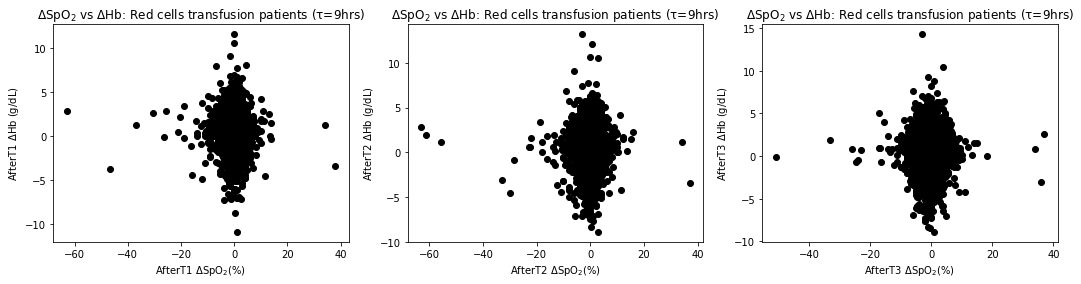

In [33]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].scatter(medI_medianAllFeatureTable['del_SPO2_1'], medI_medianAllFeatureTable['del_Hb_1'],color='black')
axs[0].set_title('$\Delta$SpO$_2$ vs $\Delta$Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0].set_xlabel('AfterT1 $\Delta$SpO$_2 (\%)$')
axs[0].set_ylabel('AfterT1 $\Delta$Hb (g/dL)')

axs[1].scatter(medI_medianAllFeatureTable['del_SPO2_2'], medI_medianAllFeatureTable['del_Hb_2'],color='black')
axs[1].set_title('$\Delta$SpO$_2$ vs $\Delta$Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1].set_xlabel('AfterT2 $\Delta$SpO$_2 (\%)$')
axs[1].set_ylabel('AfterT2 $\Delta$Hb (g/dL)')

axs[2].scatter(medI_medianAllFeatureTable['del_SPO2_3'], medI_medianAllFeatureTable['del_Hb_3'],color='black')
axs[2].set_title('$\Delta$SpO$_2$ vs $\Delta$Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2].set_xlabel('AfterT3 $\Delta$SpO$_2 (\%)$')
axs[2].set_ylabel('AfterT3 $\Delta$Hb (g/dL)')

# plt.savefig("DATA_RESULTS/delSpO2vsdelHb_RedCellsT.eps", format="eps", bbox_inches="tight", dpi=300)


Text(0, 0.5, 'Hb (g/dL) just before transfusion')

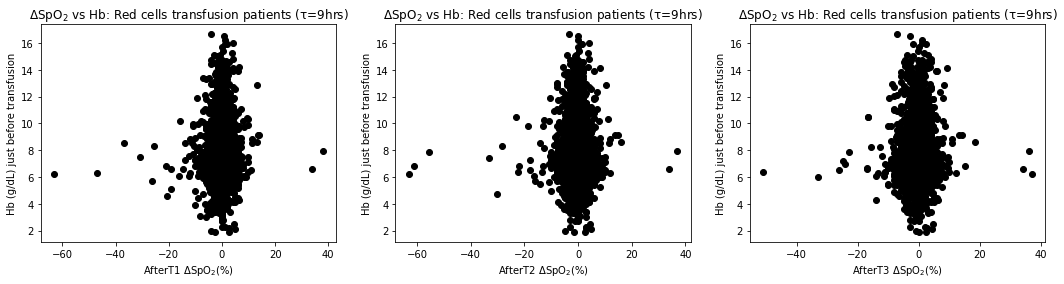

In [34]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].scatter(medianAllFeatureTable['del_SPO2_1'], medianAllFeatureTable['Hb'],color='black')
axs[0].set_title('$\Delta$SpO$_2$ vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0].set_xlabel('AfterT1 $\Delta$SpO$_2 (\%)$')
axs[0].set_ylabel('Hb (g/dL) just before transfusion')

axs[1].scatter(medianAllFeatureTable['del_SPO2_2'], medianAllFeatureTable['Hb'],color='black')
axs[1].set_title('$\Delta$SpO$_2$ vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1].set_xlabel('AfterT2 $\Delta$SpO$_2 (\%)$')
axs[1].set_ylabel('Hb (g/dL) just before transfusion')

axs[2].scatter(medianAllFeatureTable['del_SPO2_3'], medianAllFeatureTable['Hb'],color='black')
axs[2].set_title('$\Delta$SpO$_2$ vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2].set_xlabel('AfterT3 $\Delta$SpO$_2 (\%)$')
axs[2].set_ylabel('Hb (g/dL) just before transfusion')

# plt.savefig('DATA_RESULTS/delSpO2vsHb_RedCellsT.png', format="png", bbox_inches="tight", dpi=300)

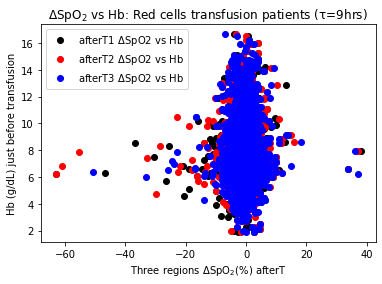

In [35]:
fig, axs = plt.subplots(figsize =(6, 4))

axs.plot(medianAllFeatureTable['del_SPO2_1'], medianAllFeatureTable['Hb'],'o',color='black')
axs.plot(medianAllFeatureTable['del_SPO2_2'], medianAllFeatureTable['Hb'],'o',color='red')
axs.plot(medianAllFeatureTable['del_SPO2_3'], medianAllFeatureTable['Hb'],'o',color='blue')
axs.set_title('$\Delta$SpO$_2$ vs Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs.set_xlabel('Three regions $\Delta$SpO$_2 (\%)$ afterT')
axs.set_ylabel('Hb (g/dL) just before transfusion')
axs.legend(['afterT1 $\Delta$SpO2 vs Hb','afterT2 $\Delta$SpO2 vs Hb','afterT3 $\Delta$SpO2 vs Hb'])

# plt.savefig('DATA_RESULTS/ThreeRegions_delSpO2vsHb_RedCellsT.eps', format="eps", bbox_inches="tight", dpi=300)

(-5.0, 9.0)

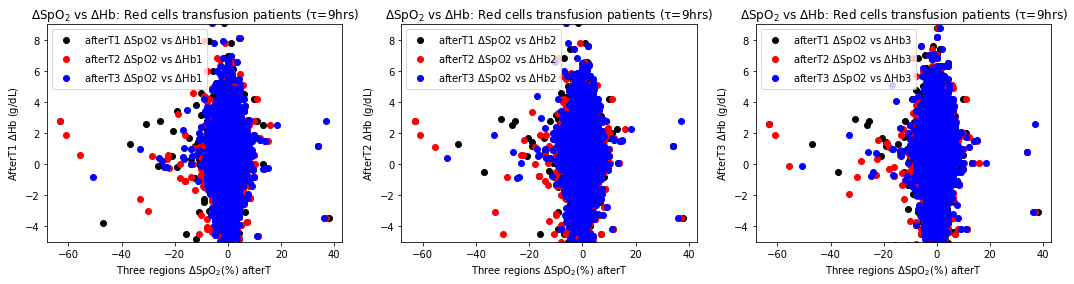

In [36]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].plot(medianAllFeatureTable['del_SPO2_1'], medianAllFeatureTable['del_Hb_1'],'o',color='black')
axs[0].plot(medianAllFeatureTable['del_SPO2_2'], medianAllFeatureTable['del_Hb_1'],'o',color='red')
axs[0].plot(medianAllFeatureTable['del_SPO2_3'], medianAllFeatureTable['del_Hb_1'],'o',color='blue')
axs[0].set_title('$\Delta$SpO$_2$ vs $\Delta$Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[0].set_xlabel('Three regions $\Delta$SpO$_2 (\%)$ afterT')
axs[0].set_ylabel('AfterT1 $\Delta$Hb (g/dL)')
axs[0].legend(['afterT1 $\Delta$SpO2 vs $\Delta$Hb1','afterT2 $\Delta$SpO2 vs $\Delta$Hb1','afterT3 $\Delta$SpO2 vs $\Delta$Hb1'])
axs[0].set_ylim([-5,9])

axs[1].plot(medianAllFeatureTable['del_SPO2_1'], medianAllFeatureTable['del_Hb_2'],'o',color='black')
axs[1].plot(medianAllFeatureTable['del_SPO2_2'], medianAllFeatureTable['del_Hb_2'],'o',color='red')
axs[1].plot(medianAllFeatureTable['del_SPO2_3'], medianAllFeatureTable['del_Hb_2'],'o',color='blue')
axs[1].set_title('$\Delta$SpO$_2$ vs $\Delta$Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[1].set_xlabel('Three regions $\Delta$SpO$_2 (\%)$ afterT')
axs[1].set_ylabel('AfterT2 $\Delta$Hb (g/dL)')
axs[1].legend(['afterT1 $\Delta$SpO2 vs $\Delta$Hb2','afterT2 $\Delta$SpO2 vs $\Delta$Hb2','afterT3 $\Delta$SpO2 vs $\Delta$Hb2'])
axs[1].set_ylim([-5,9])

axs[2].plot(medianAllFeatureTable['del_SPO2_1'], medianAllFeatureTable['del_Hb_3'],'o',color='black')
axs[2].plot(medianAllFeatureTable['del_SPO2_2'], medianAllFeatureTable['del_Hb_3'],'o',color='red')
axs[2].plot(medianAllFeatureTable['del_SPO2_3'], medianAllFeatureTable['del_Hb_3'],'o',color='blue')
axs[2].set_title('$\Delta$SpO$_2$ vs $\Delta$Hb: Red cells transfusion patients (\u03C4=9hrs)')
axs[2].set_xlabel('Three regions $\Delta$SpO$_2 (\%)$ afterT')
axs[2].set_ylabel('AfterT3 $\Delta$Hb (g/dL)')
axs[2].legend(['afterT1 $\Delta$SpO2 vs $\Delta$Hb3','afterT2 $\Delta$SpO2 vs $\Delta$Hb3','afterT3 $\Delta$SpO2 vs $\Delta$Hb3'])
axs[2].set_ylim([-5,9])

# plt.savefig('DATA_RESULTS/ThreeRegions_delSpO2vsdelHb_RedCellsT_7_24_22.png')

Text(0, 0.5, 'Median HB beforeT')

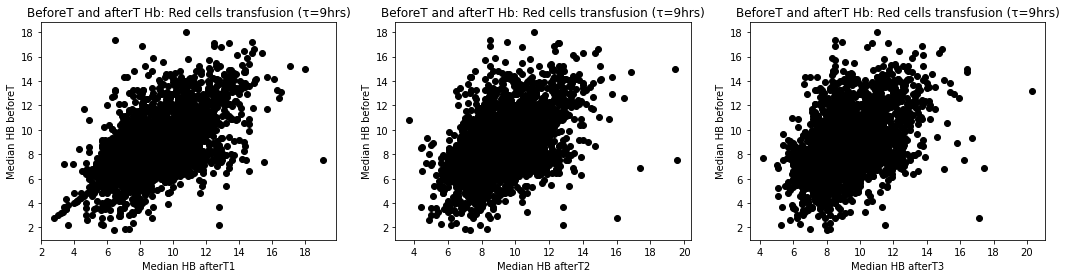

In [37]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].scatter(medianAllFeatureTable['MHB_afterT1'], medianAllFeatureTable['med_Hb_beforeT'],color='black')
axs[0].set_title('BeforeT and afterT Hb: Red cells transfusion (\u03C4=9hrs)')
axs[0].set_xlabel('Median HB afterT1')
axs[0].set_ylabel('Median HB beforeT')

axs[1].scatter(medianAllFeatureTable['MHB_afterT2'], medianAllFeatureTable['med_Hb_beforeT'],color='black')
axs[1].set_title('BeforeT and afterT Hb: Red cells transfusion (\u03C4=9hrs)')
axs[1].set_xlabel('Median HB afterT2')
axs[1].set_ylabel('Median HB beforeT')

axs[2].scatter(medianAllFeatureTable['MHB_afterT3'], medianAllFeatureTable['med_Hb_beforeT'],color='black')
axs[2].set_title('BeforeT and afterT Hb: Red cells transfusion (\u03C4=9hrs)')
axs[2].set_xlabel('Median HB afterT3')
axs[2].set_ylabel('Median HB beforeT')

# plt.savefig('DATA_RESULTS/Hb_BeforeAndAfterT_RedCellsT_7_24_22.png')

Text(0, 0.5, 'Median SF beforeT')

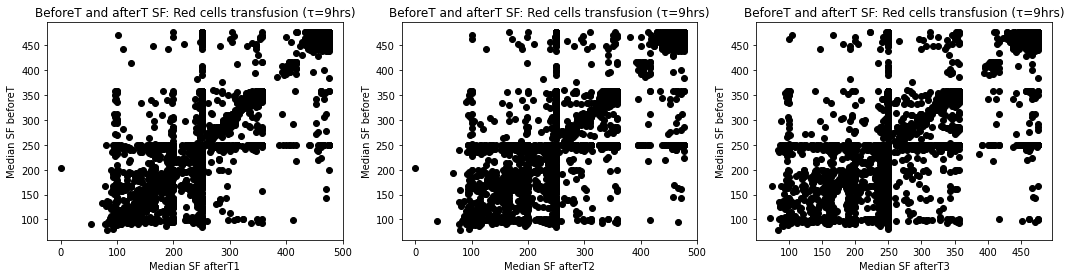

In [38]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].scatter(medianAllFeatureTable['MSF_afterT1'], medianAllFeatureTable['med_SF_beforeT'],color='black')
axs[0].set_title('BeforeT and afterT SF: Red cells transfusion (\u03C4=9hrs)')
axs[0].set_xlabel('Median SF afterT1')
axs[0].set_ylabel('Median SF beforeT')

axs[1].scatter(medianAllFeatureTable['MSF_afterT2'], medianAllFeatureTable['med_SF_beforeT'],color='black')
axs[1].set_title('BeforeT and afterT SF: Red cells transfusion (\u03C4=9hrs)')
axs[1].set_xlabel('Median SF afterT2')
axs[1].set_ylabel('Median SF beforeT')

axs[2].scatter(medianAllFeatureTable['MSF_afterT3'], medianAllFeatureTable['med_SF_beforeT'],color='black')
axs[2].set_title('BeforeT and afterT SF: Red cells transfusion (\u03C4=9hrs)')
axs[2].set_xlabel('Median SF afterT3')
axs[2].set_ylabel('Median SF beforeT')

# plt.savefig('Data_Transfusion_VitalSigns_12_18_22/SF_BeforeAndAfterT_RedCellsT_6_23_22.png')

Text(0, 0.5, 'Median PF beforeT')

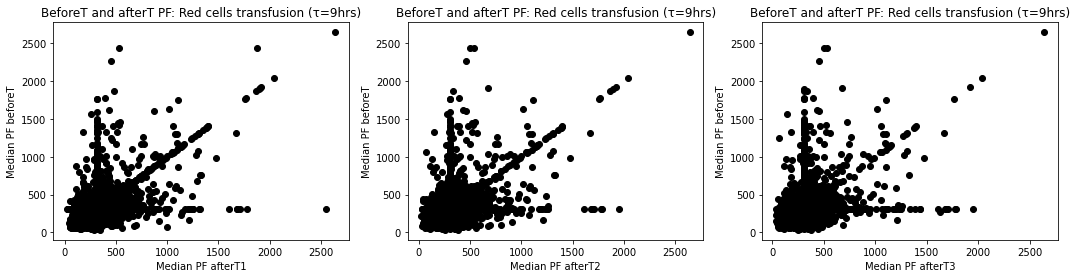

In [39]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].scatter(medianAllFeatureTable['MPF_afterT1'], medianAllFeatureTable['med_PF_beforeT'],color='black')
axs[0].set_title('BeforeT and afterT PF: Red cells transfusion (\u03C4=9hrs)')
axs[0].set_xlabel('Median PF afterT1')
axs[0].set_ylabel('Median PF beforeT')

axs[1].scatter(medianAllFeatureTable['MPF_afterT2'], medianAllFeatureTable['med_PF_beforeT'],color='black')
axs[1].set_title('BeforeT and afterT PF: Red cells transfusion (\u03C4=9hrs)')
axs[1].set_xlabel('Median PF afterT2')
axs[1].set_ylabel('Median PF beforeT')

axs[2].scatter(medianAllFeatureTable['MPF_afterT3'], medianAllFeatureTable['med_PF_beforeT'],color='black')
axs[2].set_title('BeforeT and afterT PF: Red cells transfusion (\u03C4=9hrs)')
axs[2].set_xlabel('Median PF afterT3')
axs[2].set_ylabel('Median PF beforeT')

# plt.savefig('Data_Transfusion_VitalSigns_12_18_22/PF_BeforeAndAfterT_RedCellsT_6_23_22.png')

Text(0, 0.5, 'Median SpO2 beforeT')

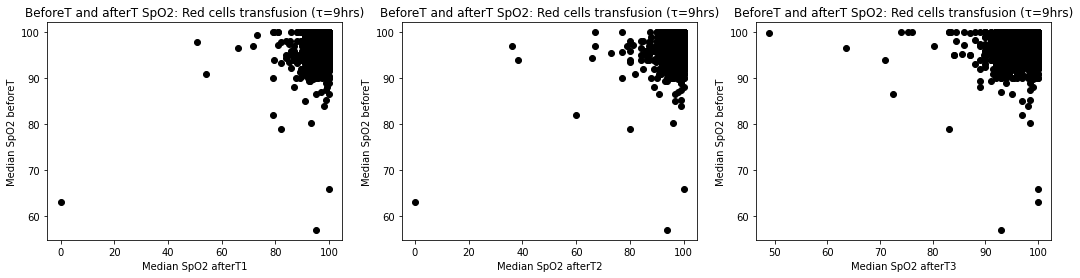

In [40]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].scatter(medianAllFeatureTable['MSPO2_afterT1'], medianAllFeatureTable['med_spo2_beforeT'],color='black')
axs[0].set_title('BeforeT and afterT SpO2: Red cells transfusion (\u03C4=9hrs)')
axs[0].set_xlabel('Median SpO2 afterT1')
axs[0].set_ylabel('Median SpO2 beforeT')

axs[1].scatter(medianAllFeatureTable['MSPO2_afterT2'], medianAllFeatureTable['med_spo2_beforeT'],color='black')
axs[1].set_title('BeforeT and afterT SpO2: Red cells transfusion (\u03C4=9hrs)')
axs[1].set_xlabel('Median SpO2 afterT2')
axs[1].set_ylabel('Median SpO2 beforeT')

axs[2].scatter(medianAllFeatureTable['MSPO2_afterT3'], medianAllFeatureTable['med_spo2_beforeT'],color='black')
axs[2].set_title('BeforeT and afterT SpO2: Red cells transfusion (\u03C4=9hrs)')
axs[2].set_xlabel('Median SpO2 afterT3')
axs[2].set_ylabel('Median SpO2 beforeT')

# plt.savefig('Data_Transfusion_VitalSigns_12_18_22/SpO2_BeforeAndAfterT_RedCellsT_6_23_22.png')

Text(0, 0.5, 'Transfused blood volume (ml)')

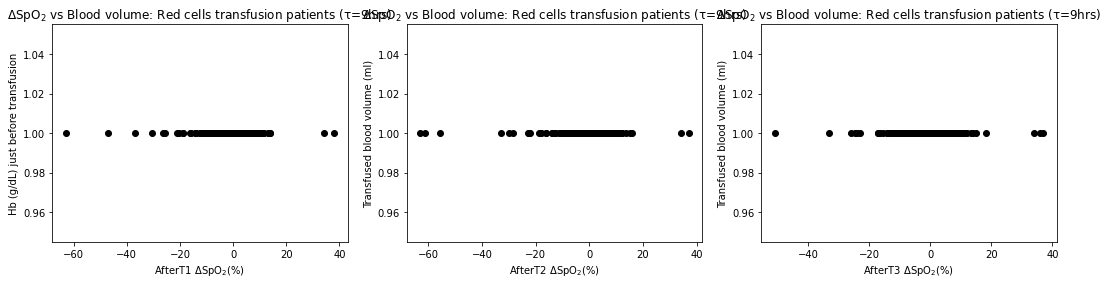

In [42]:
fig, axs = plt.subplots(1, 3, figsize =(18, 4))

axs[0].scatter(medianAllFeatureTable['del_SPO2_1'], medianAllFeatureTable['unit'],color='black')
axs[0].set_title('$\Delta$SpO$_2$ vs Blood volume: Red cells transfusion patients (\u03C4=9hrs)')
axs[0].set_xlabel('AfterT1 $\Delta$SpO$_2 (\%)$')
axs[0].set_ylabel('Hb (g/dL) just before transfusion')

axs[1].scatter(medianAllFeatureTable['del_SPO2_2'], medianAllFeatureTable['unit'],color='black')
axs[1].set_title('$\Delta$SpO$_2$ vs Blood volume: Red cells transfusion patients (\u03C4=9hrs)')
axs[1].set_xlabel('AfterT2 $\Delta$SpO$_2 (\%)$')
axs[1].set_ylabel('Transfused blood volume (ml)')

axs[2].scatter(medianAllFeatureTable['del_SPO2_3'], medianAllFeatureTable['unit'],color='black')
axs[2].set_title('$\Delta$SpO$_2$ vs Blood volume: Red cells transfusion patients (\u03C4=9hrs)')
axs[2].set_xlabel('AfterT3 $\Delta$SpO$_2 (\%)$')
axs[2].set_ylabel('Transfused blood volume (ml)')

# plt.savefig('Data_Transfusion_VitalSigns_12_18_22/delSpO2vsBloodV_RedCellsT_6_23_22.png')

Text(0, 0.5, 'Blood volume (ml)')

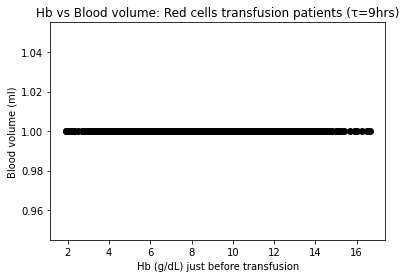

In [44]:
fig, axs = plt.subplots()

axs.scatter(medianAllFeatureTable['Hb'], medianAllFeatureTable['unit'],color='black')
axs.set_title('Hb vs Blood volume: Red cells transfusion patients (\u03C4=9hrs)')
axs.set_xlabel('Hb (g/dL) just before transfusion')
axs.set_ylabel('Blood volume (ml)')

# plt.savefig('Data_Transfusion_VitalSigns_12_18_22/HbvsBloodV_RedCellsT_6_23_22.png')

In [ ]:
# from sklearn.model_selection import train_test_split
# x = iris.iloc[:, :-1].values #last column values excluded
# y = iris.iloc[:,   -1].values #last column value

In [ ]:
len(ResponderIndex)

In [ ]:
len(NonResponderIndex)

In [ ]:
len(FileNotFoundErrorCases)

In [ ]:
len(np.unique(ResponderList))

In [ ]:
len(np.unique(NonResponderList))

In [ ]:
len(IndexErrorCases)

In [ ]:
len(ValueErrorCases)

In [ ]:
len(LenLessThan24HrIndexAfterT)

In [ ]:
len(LenLessThan24HrIndexBeforeT)

In [ ]:
len(ErrorLessThan5HrAfterTtime)

In [ ]:
#len(GoodSpO2CasesBeforeT)

In [ ]:
TransfusionVar = {'ResponderIndex': ResponderIndex, 'NonResponderIndex': NonResponderIndex, 
                 'ResponderList': ResponderList, 'NonResponderList': NonResponderList,
                 'FileNotFoundErrorCases': FileNotFoundErrorCases, 'IndexErrorCases': IndexErrorCases,
                 'ValueErrorCases': ValueErrorCases, 'LenLessThan24HrIndexAfterT': LenLessThan24HrIndexAfterT,
                 'LenLessThan24HrIndexBeforeT': LenLessThan24HrIndexBeforeT, 'ErrorLessThan5HrAfterTtime': ErrorLessThan5HrAfterTtime}
                 #'GoodSpO2CasesBeforeT': GoodSpO2CasesBeforeT}

*Saving TransfusionVar in pickle*

In [ ]:
# ###Saving TransfusionVar in pickle
# with open('TransfusionVar_6_22_22_improvFactor_2.pickle', 'wb') as handle:
#     pickle.dump(TransfusionVar, handle, protocol=pickle.HIGHEST_PROTOCOL)


###with open('TransfusionVar_5_27_22.pickle', 'rb') as handle:
###     varAll = pickle.load(handle)

**Divide Responders vs Non-Responders**

In [ ]:
#Only Responders and NonResponders are included for this study
#Starting 458 indexes (0 to ...) are---> Responders 
#After 459 index (... to ...) are---> NonResponders
lenResponders = len(ResponderIndex)
ResponderNonresponders = IntersectionBeforeDuringAfter.iloc[np.append(ResponderIndex, NonResponderIndex)]
ResponderNonresponders = ResponderNonresponders.reset_index()
ResponderNonresponders = ResponderNonresponders[['deBedTime','PAT_ID', 'csn',
       'dispense_dt_tm', 'DateStart', 'DateEnd', 'estimated_transfusion_dt_tm', 'FileStart', 'FileStop', 'product_cd_disp',
       'product_cat_cd_disp','Hb_collection_time','Hb','MedSPO2_beforeT','MedSPO2_afterT','del_SPO2']]
ResponderNonresponders

*Writing in CSV*

In [ ]:
# ResponderNonresponders.to_csv("ResponderNonresponders_6_22_22_improv_factor_2.csv")

In [ ]:
plt.figure()
plt.scatter(ResponderNonresponders['del_SPO2'], ResponderNonresponders['Hb'],color='black')
plt.title('$\Delta$SpO$_2$ vs Hb: All Patients')
plt.xlabel('$\Delta$SpO$_2 (\%)$')
plt.ylabel('Hb (g/dL)')

#plt.savefig('delSpO2vsHb_RedCellsT_6_22_22.png')

In [ ]:
plt.figure()
plt.scatter(ResponderNonresponders.iloc[:lenResponders]['del_SPO2'], ResponderNonresponders.iloc[:lenResponders]['Hb'], color='blue')
plt.title('$\Delta$SpO$_2$ vs Hb: Responders')
plt.xlabel('$\Delta$SpO$_2 (\%)$')
plt.ylabel('Hb (g/dL)')

In [ ]:
plt.figure()
plt.scatter(ResponderNonresponders.iloc[lenResponders:]['del_SPO2'], ResponderNonresponders.iloc[lenResponders:]['Hb'],color='red')
plt.title('$\Delta$SpO$_2$ vs Hb: Nonresponders')
plt.xlabel('$\Delta$SpO$_2 (\%)$')
plt.ylabel('Hb (g/dL)')

In [ ]:
plt.figure()
plt.scatter(ResponderNonresponders.iloc[:lenResponders]['del_SPO2'], ResponderNonresponders.iloc[:lenResponders]['Hb'], color='blue')
plt.scatter(ResponderNonresponders.iloc[lenResponders:]['del_SPO2'], ResponderNonresponders.iloc[lenResponders:]['Hb'],color='red')
plt.title('$\Delta$SpO$_2$ vs Hb: Responders and Nonresponders') #: Responders and Nonresponders #Red Cells Transfusion: 
plt.xlabel('$\Delta$SpO$_2 (\%)$')
plt.ylabel('Hb (g/dL)')
plt.legend(['Responders ($\Delta$SpO$_2$>2)','Nonresponders ($\Delta$SpO$_2$<2)'])
plt.ylim([2,18])

# plt.savefig('delSpO2vsHb_improvFactor_2_RedCellsT_6_22_22.png')